### Semi-supervised learning
## Multi-tasking 
Data taken from https://www.kaggle.com/datasets/prathamgrover/3d-liver-segmentation?resource=download'

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import os
import glob

        
def visualize_slices(input_batch, target_batch, recon_batch, seg_batch, slice_idx=24):
    """
    Plots a 2D slice from the middle of a 4-tensor batch.
    """
    # Use torch.no_grad() to stop tracking gradients
    with torch.no_grad():
        
        # --- 1. Process Tensors ---
        
        # Move to CPU and convert to NumPy
        # Squeeze out the channel dim (C=1)
        input_slice = input_batch.to('cpu').numpy()[0, 0, slice_idx, :, :]
        
        # Target is [B, D, H, W], no channel
        target_slice = target_batch.to('cpu').numpy()[0, slice_idx, :, :]
        
        # Recon needs detach() because it has grads
        recon_slice = recon_batch.to('cpu').detach().numpy()[0, 0, slice_idx, :, :]
        
        # Seg is the trickiest: [B, C, D, H, W]
        # We need to find the most likely class for each pixel (argmax)
        seg_logits = seg_batch.to('cpu').detach()
        seg_pred = torch.argmax(seg_logits, dim=1) # Shape: [B, D, H, W]
        seg_slice = seg_pred.numpy()[0, slice_idx, :, :]

        
        # --- 2. Plotting ---
        
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        # Plot 1: Original Input
        axes[0].imshow(input_slice, cmap='gray')
        axes[0].set_title(f"Input Image (Slice {slice_idx})")
        axes[0].axis('off')
        
        # Plot 2: Ground Truth Segmentation
        axes[1].imshow(target_slice, cmap='gray', vmin=0, vmax=NUM_CLASSES-1)
        axes[1].set_title("Target Segmentation")
        axes[1].axis('off')
        
        # Plot 3: Reconstructed Output
        axes[2].imshow(recon_slice, cmap='gray')
        axes[2].set_title("Reconstructed Image")
        axes[2].axis('off')
        
        # Plot 4: Predicted Segmentation
        axes[3].imshow(seg_slice, cmap='gray', vmin=0, vmax=NUM_CLASSES-1)
        axes[3].set_title("Predicted Segmentation")
        axes[3].axis('off')
        
        plt.tight_layout()
        plt.show()

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import os
import glob
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Configuration ---
# Using 32x32x32 input size to avoid all rounding errors
INPUT_SHAPE = (1, 32, 32, 32) # (C, D, H, W)
NUM_CLASSES = 3  # Background, Segment 1, Segment 2
LATENT_DIM = 256
BATCH_SIZE = 4
NUM_EPOCHS = 20

# !!! CHECK THIS PATH !!!
DATA_DIR = "./Task03_Liver_rs" 
# !!! CHECK THIS PATH !!!

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# --- 2. Data Loader ---
class LiverDataset(Dataset):
    def __init__(self, image_dir, label_dir, target_size=(32, 32, 32)):
        
        # Look for .nii files
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.nii")))
        self.label_paths = sorted(glob.glob(os.path.join(label_dir, "*.nii")))
        
        # Use the 32x32x32 target size
        self.target_size = target_size 
        
        assert len(self.image_paths) > 0, f"No images found in {image_dir}"
        assert len(self.label_paths) > 0, f"No labels found in {label_dir}"
        assert len(self.image_paths) == len(self.label_paths), "Image and label counts mismatch"
        
        print(f"Found {len(self.image_paths)} image/label pairs.")

    def __len__(self):
        return len(self.image_paths)

    def normalize(self, data):
        data = data - torch.min(data)
        data = data / torch.max(data)
        return data

    def __getitem__(self, idx):
        img_nii = nib.load(self.image_paths[idx])
        lbl_nii = nib.load(self.label_paths[idx])
        
        img_tensor = torch.from_numpy(img_nii.get_fdata()).float().permute(2, 1, 0).unsqueeze(0)
        lbl_tensor = torch.from_numpy(lbl_nii.get_fdata()).long().permute(2, 1, 0).unsqueeze(0)

        # Resize to 32x32x32
        img_resized = F.interpolate(img_tensor.unsqueeze(0), 
                                    size=self.target_size, 
                                    mode='trilinear', 
                                    align_corners=False).squeeze(0)
        
        lbl_resized = F.interpolate(lbl_tensor.float().unsqueeze(0), 
                                    size=self.target_size, 
                                    mode='nearest').squeeze(0).long()

        img_resized = self.normalize(img_resized)
        lbl_resized = lbl_resized.squeeze(0) 

        return img_resized, lbl_resized

# --- 3. Model Architecture ---

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size, padding=padding, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout3d(p=0.3)
        )
    def forward(self, x):
        return self.conv(x)
    
class Encoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        # Input: 1x32x32x32
        self.enc1 = ConvBlock(in_channels, 32) # -> 32x32x32
        self.pool1 = nn.MaxPool3d(2)           # -> 32x16x16
        
        self.enc2 = ConvBlock(32, 64)          # -> 64x16x16
        self.pool2 = nn.MaxPool3d(2)           # -> 64x8x8

        self.enc3 = ConvBlock(64, 128)         # -> 128x8x8
        self.pool3 = nn.MaxPool3d(2)           # -> 128x4x4
        
    def forward(self, x):
        s1 = self.enc1(x)
        p1 = self.pool1(s1)
        s2 = self.enc2(p1)
        p2 = self.pool2(s2)
        s3 = self.enc3(p2)
        p3 = self.pool3(s3) # p3 is 128x4x4
        return p3, s1, s2, s3

class Seg_decoder(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # b (bottleneck) is 256x4x4
        self.up_seg1 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2) # -> 128x8x8
        self.dec_seg1 = ConvBlock(256, 128) # 128+128 = 256
        
        self.up_seg2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2) # -> 64x16x16
        self.dec_seg2 = ConvBlock(128, 64) # 64+64 = 128

        self.up_seg3 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2) # -> 32x32x32
        self.dec_seg3 = ConvBlock(64, 32) # 32+32 = 64
        
        self.out_seg = nn.Conv3d(32, num_classes, kernel_size=1)
        
    def forward(self, b , s1, s2, s3):
        us1 = self.up_seg1(b) # 8x8x8
        ds1 = self.dec_seg1(torch.cat([us1, s3], dim=1)) # cat [8x8x8] w [8x8x8]
        
        us2 = self.up_seg2(ds1) # 16x16x16
        ds2 = self.dec_seg2(torch.cat([us2, s2], dim=1)) # cat [16x16x16] w[16x16x16]

        us3 = self.up_seg3(ds2) # 32x32x32
        ds3 = self.dec_seg3(torch.cat([us3, s1], dim=1)) # cat [32x32x32] w [32x32x32]
        us4 = self.out_seg(ds3) 
        return us4
    
class Recon_decoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        # b (bottleneck) is 256x4x4
        self.up_recon1 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2) # -> 128x8x8
        self.dec_recon1 = ConvBlock(128, 128)

        self.up_recon2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2) # -> 64x16x16
        self.dec_recon2 = ConvBlock(64, 64)

        self.up_recon3 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2) # -> 32x32x32
        self.dec_recon3 = ConvBlock(32, 32)

        self.out_recon = nn.Sequential(
            nn.Conv3d(32, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, b):
        ur1 = self.up_recon1(b)
        dr1 = self.dec_recon1(ur1)
        ur2 = self.up_recon2(dr1)
        dr2 = self.dec_recon2(ur2)
        ur3 = self.up_recon3(dr2)
        dr3 = self.dec_recon3(ur3)
        ur4 = self.out_recon(dr3)
        return ur4

Using device: cpu


In [19]:

class MultiTaskNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=3, latent_dim=512):
        super().__init__()
        
        # Commen encoder
        self.encoder = Encoder(in_channels)

        # Bottleneck 
        self.bottleneck = ConvBlock(128, 256) # -> 256x8x8x8
        
        # Feature vector for rnn input
        self.global_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.to_latent_vec = nn.Linear(256, latent_dim) # -> Bx512

        # First decoder head for segmentation with skipped connect
        self.seg_decoder = Seg_decoder(num_classes=num_classes)

        # Second decoder head reconstruction without skipped
        self.recon_decoder = Recon_decoder(in_channels=in_channels)
        

    def forward(self, x):
        # commen encoder
        x, s1, s2, s3 = self.encoder(x)
        
        # bottleneck -> could be variational
        b = self.bottleneck(x) # [B, 256, 7, 7, 7]

        # Vectorize bottleneck output 
        pooled_vec = self.global_pool(b).view(b.size(0), -1) # -<Bx256
        latent_z = self.to_latent_vec(pooled_vec)            # ->Bx256

        # Segmentation decoder head with skips
        seg_output = self.seg_decoder(b, s1, s2, s3)

        # Reconstruction decoder head without skips
        recon_output = self.recon_decoder(b)
        
        return seg_output, recon_output, latent_z


# Temporal model -> could add more dimension 
class TemporalTracker(nn.Module):
    def __init__(self, input_dim, hidden_dim=1024, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True 
        )

        # predict t+1
        self.fc = nn.Linear(hidden_dim, input_dim)

    def forward(self, z_sequence):
        # z_sequence shape -> Batch x Time_Steps x latent_dim
        lstm_out, _ = self.lstm(z_sequence)
        
        # only care about t+1
        last_step_out = lstm_out[:, -1, :] # -1 last time step +1 
        
        # fc layer for prediction
        prediction = self.fc(last_step_out)
        return prediction


In [20]:
class LiverDataset(Dataset):
    """
    Custom PyTorch Dataset for the 3D Liver Segmentation data.
    """
    def __init__(self, image_dir, label_dir, target_size = (32, 32, 32)):
        
        # --- THIS IS THE CORRECTED PART (looking for .nii) ---
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.nii")))
        self.label_paths = sorted(glob.glob(os.path.join(label_dir, "*.nii")))
        # --- END OF CORRECTION ---
        
        self.target_size = target_size # (D, H, W)
        
        # Ensure we have matched pairs
        assert len(self.image_paths) > 0, f"No images found in {image_dir}"
        assert len(self.label_paths) > 0, f"No labels found in {label_dir}"
        assert len(self.image_paths) == len(self.label_paths), \
            f"Found {len(self.image_paths)} images but {len(self.label_paths)} labels."
        
        print(f"Found {len(self.image_paths)} image/label pairs.")

    def __len__(self):
        return len(self.image_paths)

    def normalize(self, data):
        # Normalize pixel values to [0, 1]
        data = data - torch.min(data)
        data = data / torch.max(data)
        return data

    def __getitem__(self, idx):
        # 1. Load NIfTI files (nibabel handles .nii and .nii.gz the same way)
        img_nii = nib.load(self.image_paths[idx])
        lbl_nii = nib.load(self.label_paths[idx])
        
        # 2. Get data as numpy array and convert to tensor
        img_tensor = torch.from_numpy(img_nii.get_fdata()).float().permute(2, 1, 0).unsqueeze(0)
        lbl_tensor = torch.from_numpy(lbl_nii.get_fdata()).long().permute(2, 1, 0).unsqueeze(0)

        # 3. Resize
        img_resized = F.interpolate(img_tensor.unsqueeze(0), 
                                    size=self.target_size, 
                                    mode='trilinear', 
                                    align_corners=False).squeeze(0)
        
        lbl_resized = F.interpolate(lbl_tensor.float().unsqueeze(0), 
                                    size=self.target_size, 
                                    mode='nearest').squeeze(0).long()

        # 4. Normalize image
        img_resized = self.normalize(img_resized)

        # Squeeze the channel dim from the label
        lbl_resized = lbl_resized.squeeze(0) 

        return img_resized, lbl_resized

In [21]:
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- THIS IS THE CORRECTED PART ---
    
# 1. Setup DataLoaders
DATA_DIR = "./Task03_Liver_rs" 
image_folder = os.path.join(DATA_DIR, 'imagesTr')
label_folder = os.path.join(DATA_DIR, 'labelsTr')

print(image_folder)


Using device: cpu
./Task03_Liver_rs/imagesTr


In [22]:

try:
    full_dataset = LiverDataset(image_dir=image_folder, label_dir=label_folder)
    
    data_loader = DataLoader(
        dataset=full_dataset,
        batch_size=BATCH_SIZE, # BATCH_SIZE defined at top of file
        shuffle=True
        )
except Exception as e:
    print(f"Error creating dataset: {e}")
    print("Please double-check your file paths.")
    exit()

Found 123 image/label pairs.


--- Training the MultiTaskNet on Liver Data ---

--- Epoch 1/20 ---
Batch 0/31 | Total Loss: 1.4228 | Seg Loss: 1.3771 | Recon Loss: 0.0914
--- Visualizing first training batch ---


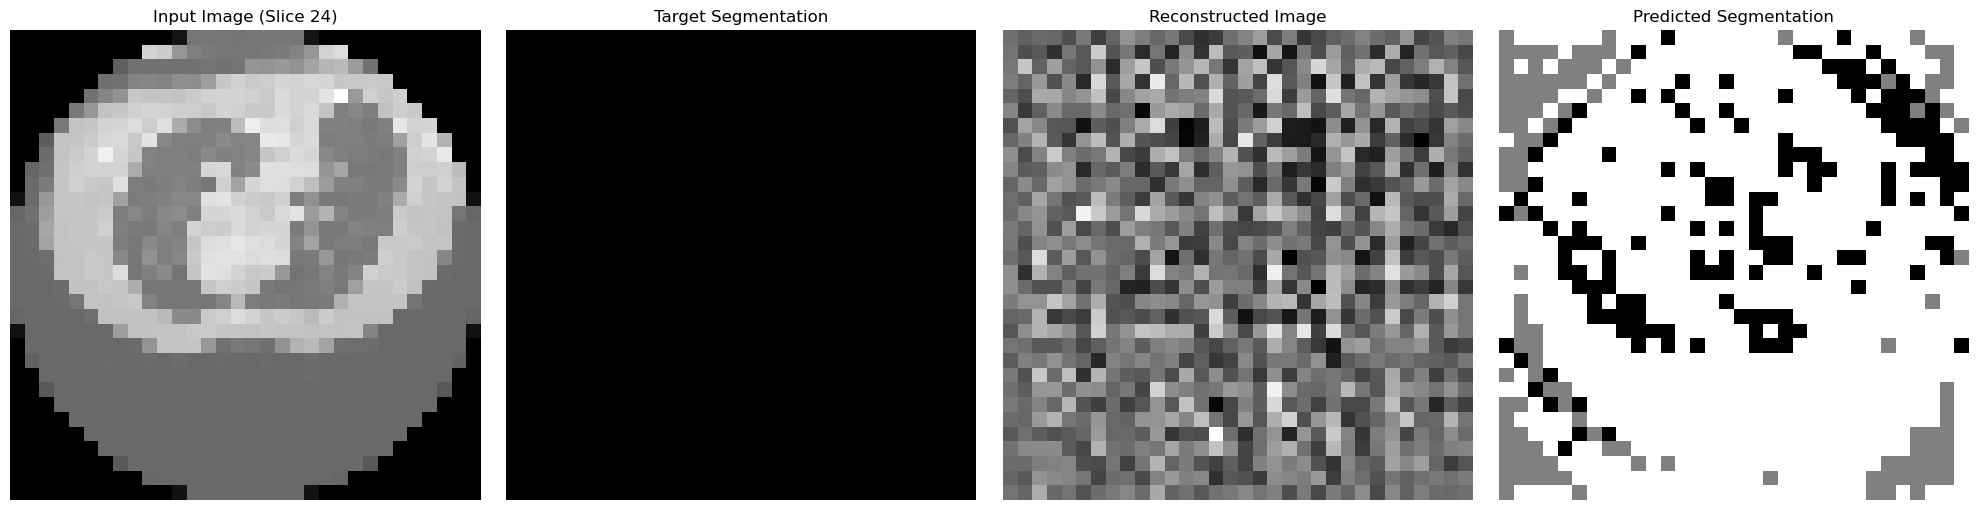

Batch 30/31 | Total Loss: 0.6184 | Seg Loss: 0.6069 | Recon Loss: 0.0229
--- Visualizing first training batch ---


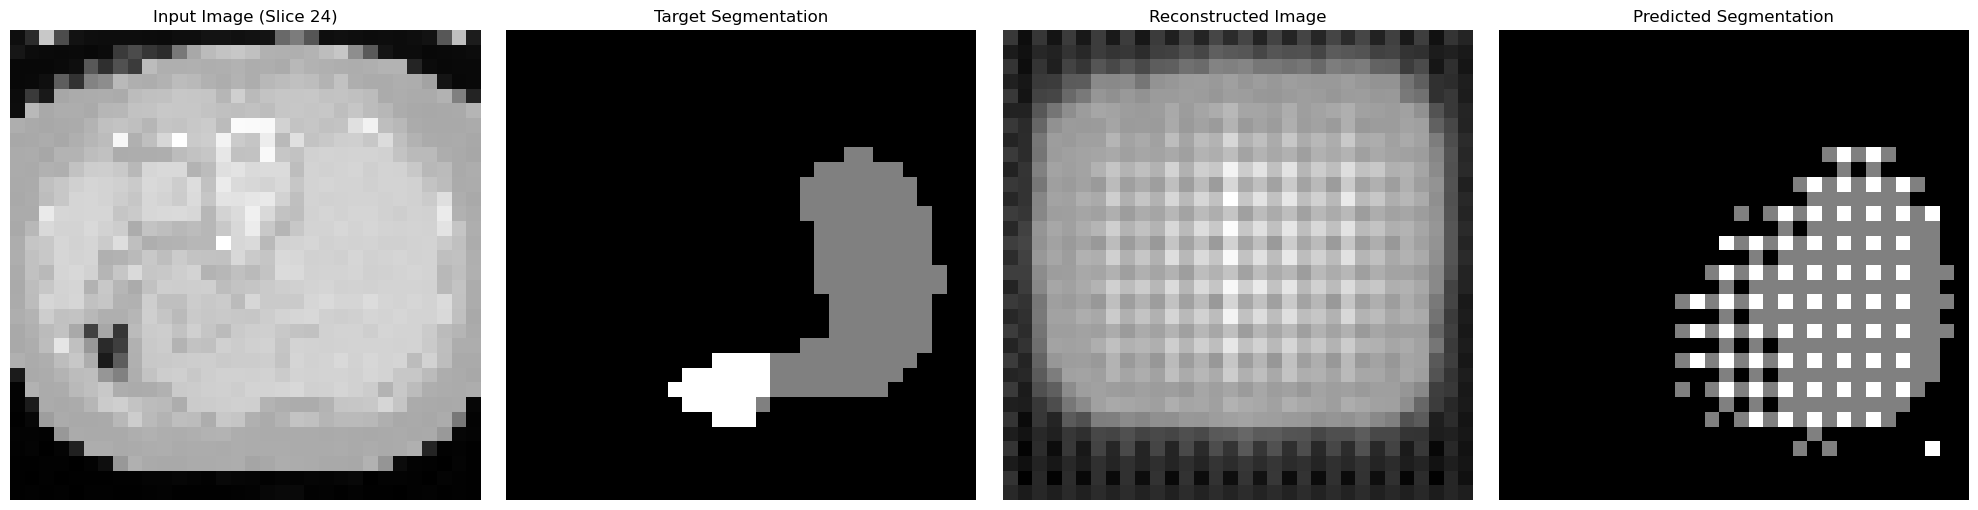


--- Epoch 2/20 ---
Batch 0/31 | Total Loss: 0.5315 | Seg Loss: 0.5131 | Recon Loss: 0.0367


KeyboardInterrupt: 

In [23]:

if __name__ == "__main__":


    # 2. Instantiate the model
    model = MultiTaskNet(
        in_channels=1, 
        num_classes=NUM_CLASSES, # NUM_CLASSES defined at top
        latent_dim=LATENT_DIM  # LATENT_DIM defined at top
    ).to(device)

    # 3. Define Losses and Optimizers
    loss_fn_seg = nn.CrossEntropyLoss()
    loss_fn_recon = nn.MSELoss()
    optimizer_model = optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-5)

    print("--- Training the MultiTaskNet on Liver Data ---")

    NUM_EPOCHS = 20
    
    for epoch in range(NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        
        model.train() 
        
        for batch_idx, (x_labeled, y_seg_target) in enumerate(data_loader):
            x_labeled = x_labeled.to(device)       
            y_seg_target = y_seg_target.to(device) 

            optimizer_model.zero_grad()
            
            seg_out, recon_out, _ = model(x_labeled)
            
            loss_seg = loss_fn_seg(seg_out, y_seg_target)
            loss_recon = loss_fn_recon(recon_out, x_labeled)
            total_loss = (loss_seg * 1.0) + (loss_recon * 0.5) 
            
            total_loss.backward()
            optimizer_model.step()
            
            if batch_idx % 30 == 0:
                print(f"Batch {batch_idx}/{len(data_loader)} | Total Loss: {total_loss.item():.4f} | Seg Loss: {loss_seg.item():.4f} | Recon Loss: {loss_recon.item():.4f}")

            if epoch % 10 == 0 and batch_idx % 30 == 0:
                print("--- Visualizing first training batch ---")
                visualize_slices(x_labeled, y_seg_target, recon_out, seg_out)



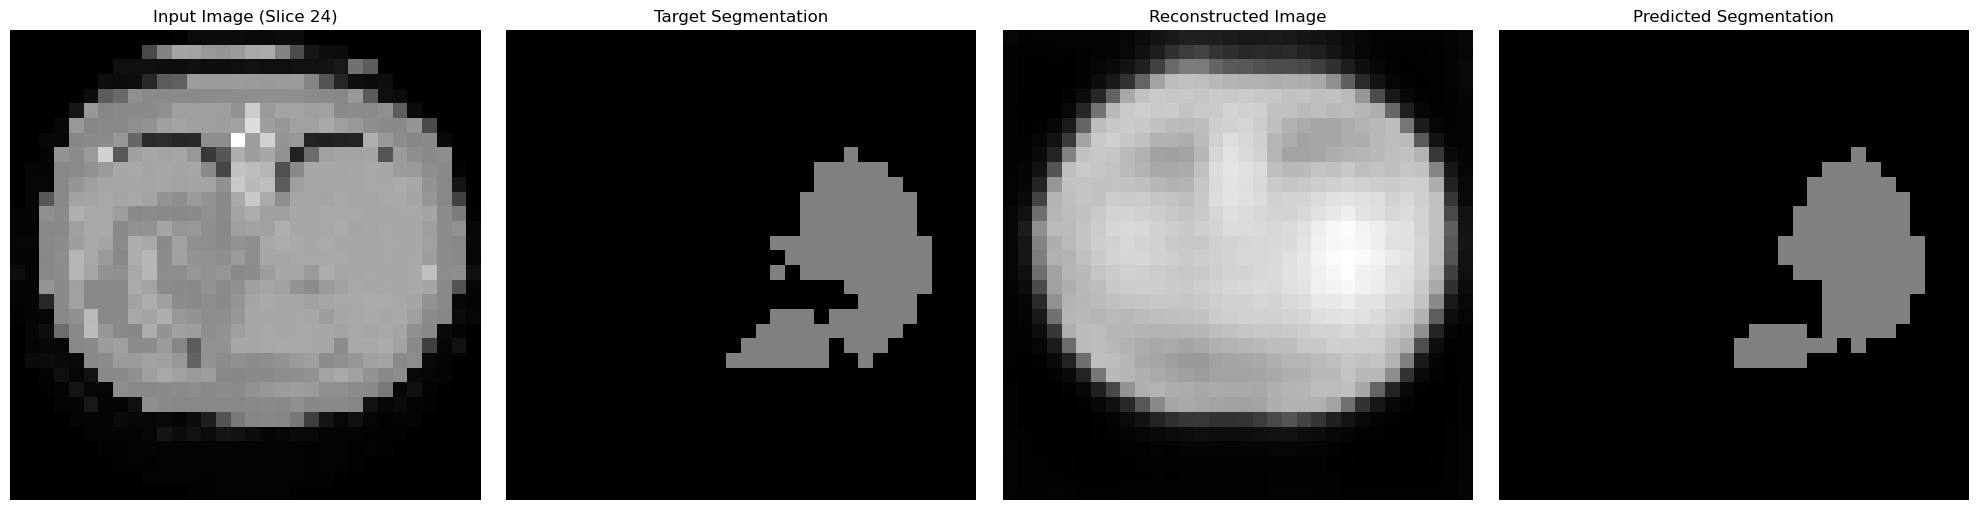

In [ ]:
visualize_slices(x_labeled, y_seg_target, recon_out, seg_out)


## The overfitting problem
The model is clearly overfitting because of the capacity of the model and the sparse data. The model is "focusing" its energy on learning the segmentation instead of learning both reconstruction and segmentation
$